In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
### TEST 123

### 목표 : 2개 classifier precision/recall 그래프 그리기

In [3]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
gender_submission = pd.read_csv('Data/gender_submission.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* Null column : Age, Cabin, Embarked

In [5]:
### data, target 구분
data = train.drop('Survived', axis=1)
target = train['Survived']

In [6]:
## categorical, numerical 구분
cat = ['PassengerId','Pclass','Sex','Ticket','Cabin','Embarked']
cat_data = data[cat]

num = ['PassengerId','SibSp', 'Parch','Age','Fare']
num_data = data[num]


In [7]:
cat_data['Cabin'].isna()

0       True
1      False
2       True
3      False
4       True
       ...  
886     True
887    False
888     True
889    False
890     True
Name: Cabin, Length: 891, dtype: bool

In [8]:
### Nan 정리 Cabin_crew 
cat_data['Cabin'] = pd.notna(cat_data['Cabin']).astype(int)

C:\Users\679oo\AppData\Local\Temp\ipykernel_18664\2566446327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_data['Cabin'] = pd.notna(cat_data['Cabin']).astype(int)


### nan 찾기 위해서 pd.isna()을 쓰자. np.isnan()은 string이 안되는듯

In [9]:
### Ticket에서 유의미한 데이터 추출 
ticket_df = pd.DataFrame(train[['PassengerId','Ticket']])

# Alphabet과 num 분리
b = ticket_df['Ticket'].str.replace('.','')
b = b.str.rsplit(pat=' ')

### alphabet이 포함되지 않은 instance에 nan을 추가로 입력 (Nan, num)
def change(x) :
    if len(x) == 1 :
        return ['NaN',x[0]]
    elif len(x) == 3: 
        return [x[0],x[2]]
    else :
        return x

c = b.apply(lambda x : change(x))
d = pd.DataFrame(c.to_list())
d

C:\Users\679oo\AppData\Local\Temp\ipykernel_18664\2500704182.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  b = ticket_df['Ticket'].str.replace('.','')


,0,1
0,A/5,21171
1,PC,17599
2,STON/O2,3101282
3,NaN,113803
4,NaN,373450
...,...,...
886,NaN,211536
887,NaN,112053
888,W/C,6607
889,NaN,111369


In [10]:
d[0].sort_values().unique()

array(['A/4', 'A/5', 'A/S', 'A4', 'A5', 'C', 'CA', 'CA/SOTON', 'FC',
       'FCC', 'Fa', 'NaN', 'P/PP', 'PC', 'PP', 'SC', 'SC/A4', 'SC/AH',
       'SC/PARIS', 'SC/Paris', 'SCO/W', 'SO/C', 'SO/PP', 'SOC', 'SOP',
       'SOTON/O2', 'SOTON/OQ', 'SP', 'STON/O', 'STON/O2', 'SW/PP', 'W/C',
       'WE/P', 'WEP'], dtype=object)

In [11]:
# 오탈자 제거
d[0] = d[0].str.replace('A5','A/5')
d[0] = d[0].str.replace('A4','A/4')
d[0] = d[0].str.replace('WEP','WE/P')
d[0] = d[0].str.replace('SOC','SO/C')
d[0] = d[0].str.replace('SOP','SO/P')
d[0] = d[0].str.replace('STON/O','SOTON/O2')

d[0].unique()

array(['A/5', 'PC', 'SOTON/O22', 'NaN', 'PP', 'CA', 'SC/Paris', 'SC/A/4',
       'A/4', 'SP', 'SO/C', 'W/C', 'SOTON/OQ', 'WE/P', 'SOTON/O2', 'C',
       'SC/PARIS', 'SO/P', 'Fa', 'FCC', 'SW/PP', 'SCO/W', 'P/PP', 'SC',
       'SC/AH', 'A/S', 'SO/PP', 'FC', 'CA/SOTON'], dtype=object)

In [12]:
# Num 앞 두자리, 앞 한자리 추출
d[2] = [a[0:2] for a in d[1]]
d[3] = [a[0:1] for a in d[1]]

In [13]:
### 변경사항 column에 추가
cat_data['ticket_al'] = d[0]
cat_data['ticket_num_2'] = d[2]
cat_data['ticket_num_1'] = d[3] 
cat_data['ticket_fullnum'] = d[1]
cat_data['survived'] = target

cat_data.head(3)

C:\Users\679oo\AppData\Local\Temp\ipykernel_18664\3848855095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_data['ticket_al'] = d[0]
C:\Users\679oo\AppData\Local\Temp\ipykernel_18664\3848855095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_data['ticket_num_2'] = d[2]
C:\Users\679oo\AppData\Local\Temp\ipykernel_18664\3848855095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,PassengerId,Pclass,Sex,Ticket,Cabin,Embarked,ticket_al,ticket_num_2,ticket_num_1,ticket_fullnum,survived
0,1,3,male,A/5 21171,0,S,A/5,21,2,21171,0
1,2,1,female,PC 17599,1,C,PC,17,1,17599,1
2,3,3,female,STON/O2. 3101282,0,S,SOTON/O22,31,3,3101282,1


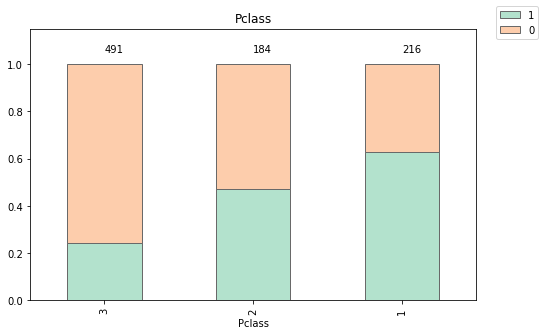

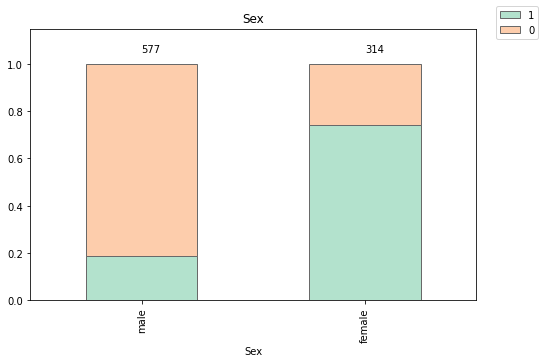

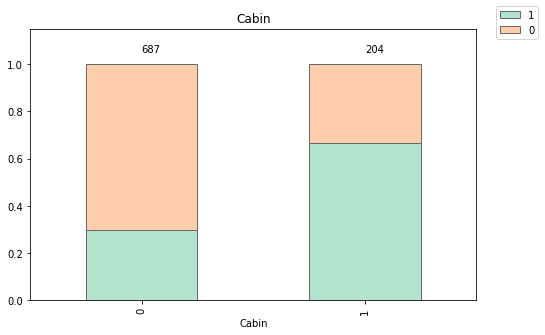

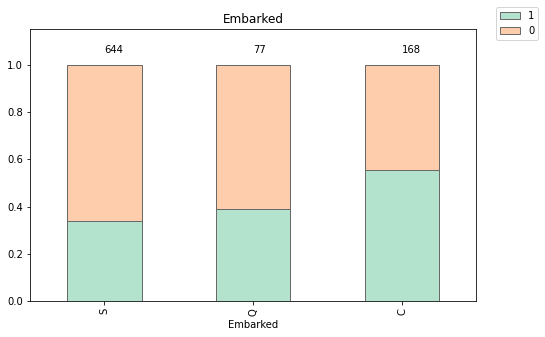

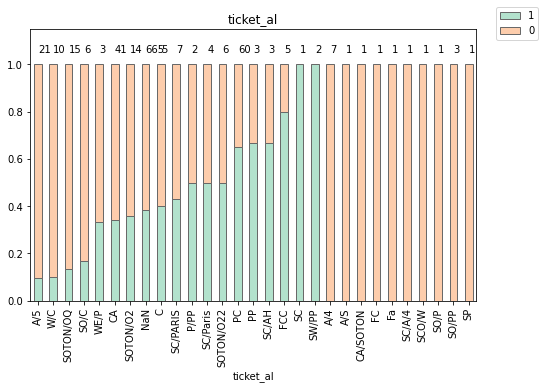

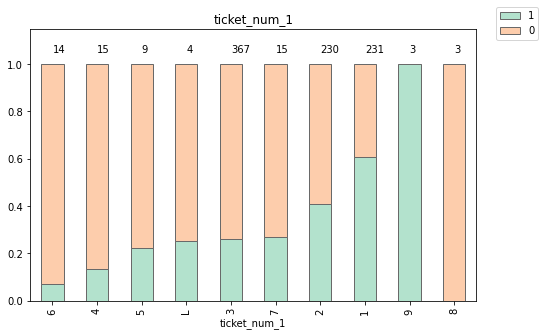

In [14]:
### Survive와 categorical

sns.set_palette("Pastel2")
new_cat = cat_data.columns.drop(['PassengerId','Ticket','ticket_fullnum','survived','ticket_num_2'])
for num, col in enumerate(new_cat) :
    a = cat_data.pivot_table(index=col,columns='survived', aggfunc='size')
    b = a.div(a.sum(axis=1),axis=0).sort_values(by=1).reindex(columns=[1,0])
    b.plot.bar(
            figsize=(8,5),
            edgecolor='dimgray',
            stacked=True, 
            )
    plt.title(col)
    plt.ylim(0,1.15)
    plt.legend(bbox_to_anchor=(1.15,1.1))
    for num, i in enumerate(b.index) : 
        plt.text(x=num, y=1.05, s=a.sum(axis=1)[i].astype(int))


    # a.reindex(columns=[1,0]).plot.bar(figsize=(10,6),edgecolor='dimgray',stacked=True, color={0: "w", 1: "tab:gray"},)


In [15]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119


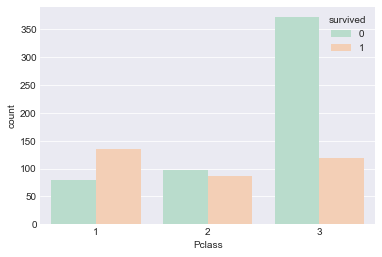

In [16]:
### Seaborn으로 그려보기
# sns.set_palette("gist_yarg")
# plt.style.available
plt.style.use("seaborn-darkgrid")
for col in ['Pclass'] :
    a = cat_data.pivot_table(index=col, columns='survived',aggfunc='size')
    print(a)
    sns.countplot(x='Pclass', hue='survived',data = cat_data)

In [17]:
new_num_data = num_data.drop(columns='Age').set_index('PassengerId')
new_cat_data = cat_data.drop(columns=['ticket_al','ticket_num_2','survived','Ticket','ticket_fullnum'])
# cat_data.set_index('PassengerId', inplace=True )
# new_num_data.set_index('PassengerId', inplace=True )
data = new_num_data.join(new_cat_data).reset_index(drop=True)
data

,SibSp,Parch,Fare,PassengerId,Pclass,Sex,Cabin,Embarked,ticket_num_1
0,1,0,7.2500,2.0,1.0,female,1.0,C,1
1,1,0,71.2833,3.0,3.0,female,0.0,S,3
2,0,0,7.9250,4.0,1.0,female,1.0,S,1
3,1,0,53.1000,5.0,3.0,male,0.0,S,3
4,0,0,8.0500,6.0,3.0,male,0.0,Q,3
...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,888.0,1.0,female,1.0,S,1
887,0,0,30.0000,889.0,3.0,female,0.0,S,6
888,1,2,23.4500,890.0,1.0,male,1.0,C,1
889,0,0,30.0000,891.0,3.0,male,0.0,Q,3


In [18]:
### Normalization
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

one_hot = OneHotEncoder(handle_unknown='ignore')
norm = StandardScaler()



preprocessor = ColumnTransformer([
    ('one-hot-encoder', one_hot, data.columns[4:]),
    ('standardscaler', norm, data.columns[:3])
])


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_validate
model_logistic = make_pipeline(preprocessor, LogisticRegression())
cv_result_logistic = cross_val_predict(model_logistic, data, target, cv=5, method='predict_proba' )


In [20]:
from sklearn.ensemble import GradientBoostingClassifier
model_Gradient = make_pipeline(preprocessor, GradientBoostingClassifier())
cv_result_Gradient = cross_val_predict(model_Gradient, data, target, cv=5,method='predict_proba' )

In [21]:
from sklearn.ensemble import HistGradientBoostingClassifier
model_Hist = make_pipeline(preprocessor, HistGradientBoostingClassifier())
# cv_result_Hist = cross_val_predict(model_Hist, data, target, cv=5,method='predict_proba' )

In [22]:
from sklearn.linear_model import SGDClassifier
model_sgd = make_pipeline(preprocessor, SGDClassifier())
cv_result_sgd = cross_val_predict(model_sgd, data, target, cv=5,method='decision_function' )

from sklearn.metrics import precision_recall_curve
# y_scores_forest = cv_result_Hist[:, 0] # score = proba of positive class
precisions, recalls, thresholds = precision_recall_curve(target, cv_result_sgd)

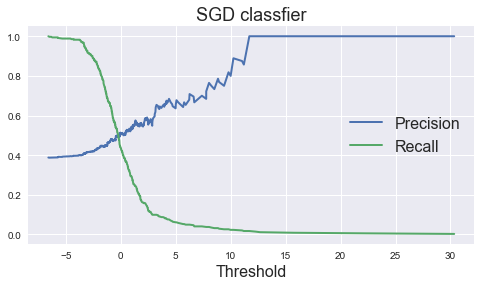

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.style.use('seaborn')
    # plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    # plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.plot(thresholds, precisions[:-1], label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    # plt.axis([-50000, 50000, 0, 1])             # Not shown



# recall_90_precision = recalls[np.argmax(precisions >= 0.50)]
# threshold_90_precision = thresholds[np.argmax(precisions >= 0.50)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds) 
plt.title('SGD classfier',fontsize=18)

plt.show()

In [24]:
from sklearn.metrics import roc_curve,confusion_matrix,ConfusionMatrixDisplay
# score = proba of positive class
fpr_sgd,tpr_sgd,thresholds_sgd = roc_curve(target, cv_result_sgd)
fpr_Gradient, tpr_Gradient, thresholds_Gradient = roc_curve(target,cv_result_Gradient[:, 1])
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(target,cv_result_logistic[:, 1])
# fpr_Hist, tpr_Hist, thresholds_Hist = roc_curve(target,cv_result_Hist[:, 1])

In [25]:
threshold = 1
a = ( fpr_logistic >threshold-0.001) & (fpr_logistic < threshold+0.01)
b = np.where(a)[0][0]
pred_log = (cv_result_logistic[:,1] > thresholds_logistic[b])
# thresholds_logistic[-4]
# thresholds_logistic[b]
np.where(a)[0]

array([428], dtype=int64)

In [39]:
def roc_logit(threshold) :
    a = ( fpr_logistic >threshold-0.001) & (fpr_logistic < threshold+0.08)
    b = np.where(a)[0][0]
#     if thresholds == 1: 
#         b= len(fpr_logistic)
    log_x, log_y = fpr_logistic[b], tpr_logistic[b] 

    ### ROC Curve
    fig, ax = plt.subplots(figsize=[8, 8])
    # ax.figure(figsize=(8,8))
    sns.set_palette('Set2')
    ax.plot(fpr_logistic, tpr_logistic, linewidth=2, label='logistic')
    ax.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    # ax.grid(True)
    # ax.legend()

    ax.plot([log_x],[log_y],'ro')
    ax.plot([log_x,log_x],[0,log_y],'r:')
    ax.plot([0,log_x],[log_y,log_y],'r:')

    plt.xlim(0,1.01)
    plt.ylim(0,1.01)

    plt.title('ROC curve of Logistic_regression', fontsize=18)
    plt.xlabel('FP rate',fontsize=14)
    plt.ylabel('TP rate',fontsize=14)



    # confusion matrix
    pred_log = (cv_result_logistic[:,1] >= thresholds_logistic[b])
    con_max = confusion_matrix(target,pred_log,labels=[1, 0])

    ax2 = fig.add_axes([0.55, 0.2, 0.25, 0.3])
    ax2.grid(False)
    ConfusionMatrixDisplay(con_max).plot(colorbar=False,cmap='PuBu',ax=ax2)
    plt.xlabel('Predicted label',fontsize=14)
    plt.ylabel('True label',fontsize=14)
    plt.xticks([1,0],['False','True'],fontsize=12)
    plt.yticks([1,0],['False','True'],fontsize=12)


In [40]:
%matplotlib inline
from ipywidgets import interact,widgets, Layout
from ipywidgets.embed import embed_minimal_html
slider = widgets.FloatSlider(min=0.00,max=1.0,step=0.2, value=1.0, layout=Layout(width='500px'))
slider.style.handle_color = 'lightblue'
interact(roc_logit, threshold=slider)

interactive(children=(FloatSlider(value=1.0, description='threshold', layout=Layout(width='500px'), max=1.0, s…

<function __main__.roc_logit(threshold)>

In [28]:
# def roc_logit(threshold) :
#     a = ( fpr_logistic >threshold-0.01) & (fpr_logistic < threshold+0.01)
    # b =np.where(a)[0][0]
#     log_x, log_y = fpr_logistic[b], tpr_logistic[b] 

#     ### ROC Curve
#     plt.figure(figsize=(8,8))
#     sns.set_palette('Set2')
#     plt.plot(fpr_logistic, tpr_logistic, linewidth=2, label='logistic')
#     plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
#     plt.grid(True)
#     # plt.legend()

#     plt.plot([log_x],[log_y],'ro')
#     plt.plot([log_x,log_x],[0,log_y],'r:')
#     plt.plot([0,log_x],[log_y,log_y],'r:')

#     plt.xlim(0,1.01)
#     plt.ylim(0,1.01)

#     plt.title('ROC curve of Logistic_regression', fontsize=18)
#     plt.xlabel('FP rate',fontsize=14)
#     plt.ylabel('TP rate',fontsize=14)


# roc_logit(0.3)


Text(0, 0.5, 'TP rate')

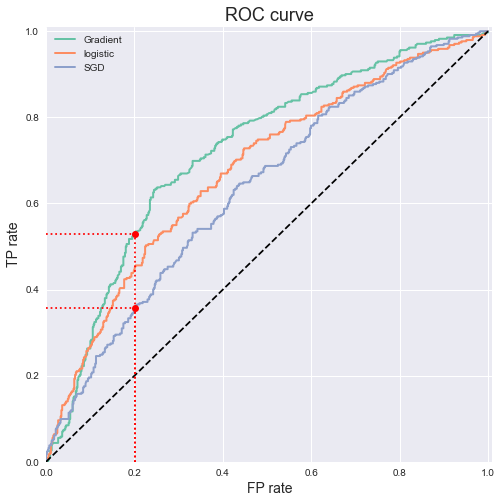

In [29]:
### ROC Curve
a = ( fpr_Gradient >0.2) & (fpr_Gradient < 0.209)
b =np.where(a)[0][0]
gra_x, gra_y = fpr_Gradient[b], tpr_Gradient[b] 

c = ( fpr_sgd >0.2) & (fpr_sgd < 0.209)
d =np.where(c)[0][0]
sgd_x, sgd_y = fpr_Gradient[b], tpr_sgd[d] 
plt.figure(figsize=(8,8))
sns.set_palette('Set2')
# plt.plot(fpr_Hist, tpr_Hist, linewidth=2, label='Hist')
plt.plot(fpr_Gradient, tpr_Gradient, linewidth=2, label='Gradient')
plt.plot(fpr_logistic, tpr_logistic, linewidth=2, label='logistic')
plt.plot(fpr_sgd, tpr_sgd, linewidth=2,label='SGD')
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.grid(True)
plt.legend()
plt.plot([gra_x],[gra_y],'ro')
plt.plot([gra_x,gra_x],[0,gra_y],'r:')
plt.plot([0,gra_x],[gra_y,gra_y],'r:')

plt.plot([sgd_x],[sgd_y],'ro')
plt.plot([sgd_x,sgd_x],[0,sgd_y],'r:')
plt.plot([0,sgd_x],[sgd_y,sgd_y],'r:')
plt.xlim(0,1.01)
plt.ylim(0,1.01)
plt.title('ROC curve', fontsize=18)
plt.xlabel('FP rate',fontsize=14)
plt.ylabel('TP rate',fontsize=14)

In [30]:
gradient_pop = []
for i in range(len(thresholds_Gradient)) :
    a = cv_result_Gradient[:,1] > thresholds_Gradient[i]
    num_arr = np.where(a)
    P = len(num_arr[0])
    gradient_pop.append(P)

sgd_pop = []
for i in range(len(thresholds_sgd)) :
    a = cv_result_sgd > thresholds_sgd[i]
    num_arr = np.where(a)
    P = len(num_arr[0])
    sgd_pop.append(P)

logistic_pop = []
for i in range(len(thresholds_logistic)) :
    a = cv_result_logistic[:,1] > thresholds_logistic[i]
    num_arr = np.where(a)
    P = len(num_arr[0])
    logistic_pop.append(P)

gradient_pop = np.array(gradient_pop) / len(target)
sgd_pop = np.array(sgd_pop) / len(target)
logistic_pop = np.array(logistic_pop) / len(target)

print(gradient_pop[-5:],sgd_pop[-5:],logistic_pop[-5:])

[0.98653199 0.98765432 0.98989899 0.99775533 0.99887767] [0.98316498 0.98428732 0.98653199 0.98765432 0.99887767] [0.99102132 0.99214366 0.99326599 0.99551066 0.99887767]


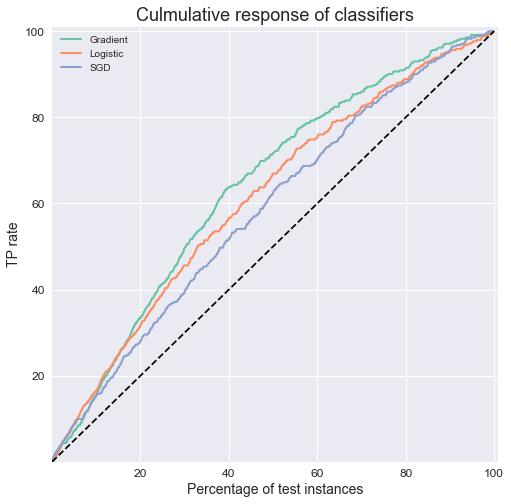

In [31]:
sns.set_palette('Set2')
plt.figure(figsize=(8,8))
plt.plot(gradient_pop,tpr_Gradient,linewidth=2,label='Gradient')
plt.plot(logistic_pop,tpr_logistic,linewidth=2,label='Logistic')
plt.plot(sgd_pop,tpr_sgd,linewidth=2,label='SGD')
plt.plot([0,1],[0,1], 'k--')

plt.xlim(0,1.01)
plt.ylim(0,1.01)
plt.xticks([0.2,0.4,0.6,0.8,1.0], labels=[20,40,60,80,100], fontsize=12)
plt.yticks([0.2,0.4,0.6,0.8,1.0], labels=[20,40,60,80,100], fontsize=12)
plt.title('Culmulative response of classifiers', fontsize=18)
plt.xlabel('Percentage of test instances',fontsize=14)
plt.ylabel('TP rate',fontsize=14)
plt.grid(True)
plt.legend()

In [32]:
### Lift = base rate ex) 8 lift = 8 TP/base rate

'''base rate는 특정 category의 집단 내 비율임 예시) 대한민국 남성 base rate 0.52 여성 0.48
lift는 TP/base rate 개수 임'''

t_mean = target.mean()
target_np = np.array(target)

gradient_lift = []
for i in range(len(thresholds_Gradient)) :
    a = cv_result_Gradient[:,1] > thresholds_Gradient[i]
    num_arr = np.where(a)
    TP = sum(target[num_arr[0]])
    b_r = len(num_arr[0])*t_mean
    lift = TP/b_r
    gradient_lift.append(lift)

sgd_lift = []
for i in range(len(thresholds_sgd)) :
    a = cv_result_sgd > thresholds_sgd[i]
    num_arr = np.where(a)
    TP = sum(target[num_arr[0]])
    b_r = len(num_arr[0])*t_mean
    lift = TP/b_r
    sgd_lift.append(lift)

logistic_lift = []
for i in range(len(thresholds_logistic)) :
    a = cv_result_logistic[:,1] > thresholds_logistic[i]
    num_arr = np.where(a)
    TP = sum(target[num_arr[0]])
    b_r = len(num_arr[0])*t_mean
    lift = TP/b_r
    logistic_lift.append(lift)

##과거 lift = TP/b_r로 착각함
# num_arr = np.where(a)
    # P = np.ones(len(num_arr[0])) == target[num_arr[0]]
    # TP = P.sum()
    # b_r = len(num_arr[0])*t_mean
    # lift = TP/b_r


C:\Users\679oo\AppData\Local\Temp\ipykernel_18664\2942228153.py:15: RuntimeWarning: invalid value encountered in double_scalars
  lift = TP/b_r
C:\Users\679oo\AppData\Local\Temp\ipykernel_18664\2942228153.py:15: RuntimeWarning: invalid value encountered in double_scalars
  lift = TP/b_r
C:\Users\679oo\AppData\Local\Temp\ipykernel_18664\2942228153.py:24: RuntimeWarning: invalid value encountered in double_scalars
  lift = TP/b_r
C:\Users\679oo\AppData\Local\Temp\ipykernel_18664\2942228153.py:24: RuntimeWarning: invalid value encountered in double_scalars
  lift = TP/b_r
C:\Users\679oo\AppData\Local\Temp\ipykernel_18664\2942228153.py:33: RuntimeWarning: invalid value encountered in double_scalars
  lift = TP/b_r
C:\Users\679oo\AppData\Local\Temp\ipykernel_18664\2942228153.py:33: RuntimeWarning: invalid value encountered in double_scalars
  lift = TP/b_r


In [33]:
a = (sgd_pop >0.19) & (sgd_pop < 0.201)
sgd_point = sgd_lift[np.where(a)[0][0]]

a = (gradient_pop > 0.19) & (gradient_pop < 0.20)
gradient_point = gradient_lift[np.where(a)[0][0]]


Text(0, 0.5, 'Lift')

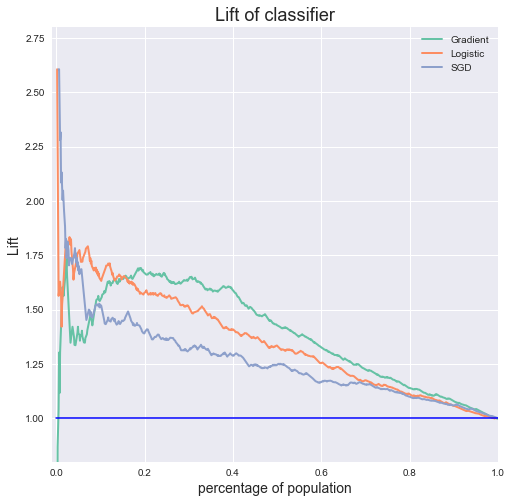

In [34]:
plt.figure(figsize=(8,8))
plt.plot(gradient_pop,gradient_lift,label='Gradient',linewidth=2)
plt.plot(logistic_pop,logistic_lift,label='Logistic',linewidth=2)
plt.plot(sgd_pop,sgd_lift,label='SGD',linewidth=2)
plt.plot([0,1],[1,1],'b-',linewidth=1.5)
plt.xlim(-0.01,1)
plt.ylim(0.8,2.8)


plt.legend()
plt.title('Lift of classifier',fontsize=18)
plt.xlabel('percentage of population',fontsize=14)
plt.ylabel('Lift',fontsize=14)


# plt.plot([0.2],[sgd_point],'ro')
# plt.plot([0.2,0.2],[0,sgd_point],'r:')
# plt.plot([0,0.2],[sgd_point,sgd_point],'r:')

# plt.plot([0.2],[gradient_point],'ro')
# plt.plot([0.2,0.2],[0,gradient_point],'r:')
# plt.plot([0,0.2],[gradient_point,gradient_point],'r:')

In [35]:
import scikitplot

ModuleNotFoundError: No module named 'scikitplot'